In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import InterpolatedUnivariateSpline as ius
from scipy.stats import gaussian_kde

In [2]:
#Matplotlib Parameters
plt.rcParams['axes.linewidth'] = 1.75

rc_params = {'backend': 'pdf',
             'axes.labelsize': 24,
             'axes.titlesize': 32,
             'font.size': 24,
             'legend.fontsize': 18,
             'xtick.labelsize': 18,
             'ytick.labelsize': 18,
             'font.family': 'serif',
             'mathtext.fontset': 'cm',         # Use Computer Modern math fonts (LaTeX style)
             'mathtext.rm': 'serif',  
             #'font.sans-serif': ['Bitstream Vera Sans'],
             #'font.serif': ['Times New Roman'],
             #'text.latex.preamble': r'\usepackage{amsmath} \usepackage{amssymb} \usepackage{amsfonts}',
             #'text.usetex':False,
             'lines.linewidth': 3
            }

plt.rcParams["patch.force_edgecolor"] = True
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams.update(rc_params)

In [ ]:
eos_data = np.loadtxt('/work/williams5/testing-urs/EOS/MMcs_mrl_soft.dat')
eos_mass_soft = eos_data[:,1]
eos_r_soft = eos_data[:,0]
eos_lambda_soft = eos_data[:,2]

eos_data = np.loadtxt('/work/williams5/testing-urs/EOS/MMcs_mrl_stiff.dat')

eos_mass_stiff = eos_data[:,1]
eos_r_stiff = eos_data[:,0]
eos_lambda = eos_data[:,2]

GW170817 = np.loadtxt('./GW170817_posterior_samples.dat')
NICER = np.loadtxt('./NICER_posterior_samples.txt')

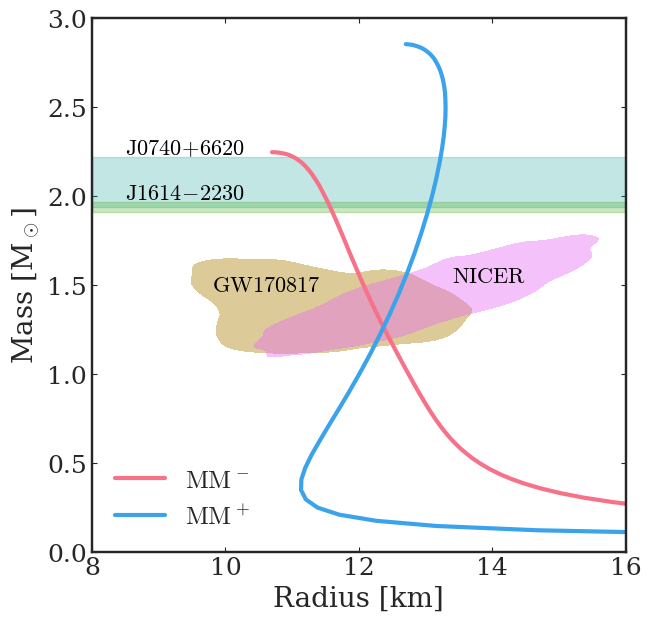

In [ ]:
# Set rcParams first
plt.rcParams.update({
    'axes.linewidth': 1.75,
    'axes.labelsize': 20,
    'axes.titlesize': 32,
    'font.size': 24,
    'legend.fontsize': 18,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'font.family': 'serif',
    'mathtext.fontset': 'cm',
    'lines.linewidth': 3,
    'patch.force_edgecolor': True,
    'axes.unicode_minus': False
})

# -------------------
# Husl palette
palette = sns.color_palette("husl")

# -------------------
def plot_2d_kde(x_samples, y_samples, ax, fill_color, alpha_fill=0.5, grid_size=150):
    """Plot 2D KDE 90% credible region with colored fill only."""
    xy = np.vstack([x_samples, y_samples])
    kde = gaussian_kde(xy)

    xmin, xmax = np.min(x_samples), np.max(x_samples)
    ymin, ymax = np.min(y_samples), np.max(y_samples)

    # 2D grid
    X, Y = np.mgrid[xmin:xmax:grid_size*1j, ymin:ymax:grid_size*1j]
    positions = np.vstack([X.ravel(), Y.ravel()])
    Z = np.reshape(kde(positions).T, X.shape)

    # 90% contour level
    Z_flat = Z.flatten()
    Z_sort = np.sort(Z_flat)
    cdf = np.cumsum(Z_sort)
    cdf /= cdf[-1]
    level_90 = Z_sort[np.searchsorted(cdf, 1-0.9)]

    # Fill credible region
    ax.contourf(X, Y, Z, levels=[level_90, Z.max()], colors=[fill_color], alpha=alpha_fill)

# -------------------
# GW170817 heavier & lighter
x_heavy, y_heavy = GW170817[:, 4], GW170817[:, 0]
x_light, y_light = GW170817[:, 5], GW170817[:, 1]
x_gw = np.concatenate([x_heavy, x_light])
y_gw = np.concatenate([y_heavy, y_light])

# NICER downsample
N_sample = 5000
if len(NICER) > N_sample:
    idx = np.random.choice(len(NICER), N_sample, replace=False)
    x_nicer, y_nicer = NICER[idx, 0], NICER[idx, 1]
else:
    x_nicer, y_nicer = NICER[:, 0], NICER[:, 1]

# Pulsar mass bands
pulsars = [
    {"name": "J0740+6620", "mass": 2.08, "err_plus": 0.14, "err_minus": 0.14, "color": palette[3], "alpha": 0.3},
    {"name": "J1614−2230", "mass": 1.937, "err_plus": 0.028, "err_minus": 0.028, "color": palette[2], "alpha": 0.3}
]

# -------------------
# Plot
fig, ax = plt.subplots(figsize=(7,7))
sns.set_style("white")  # no grid

# GW170817
plot_2d_kde(x_gw, y_gw, ax=ax, fill_color=palette[1], alpha_fill=0.5)

# NICER
plot_2d_kde(x_nicer, y_nicer, ax=ax, fill_color=palette[5], alpha_fill=0.4)

# Find turning point (maximum mass) index for each EOS
idx_soft = np.argmax(eos_mass_soft)
idx_stiff = np.argmax(eos_mass_stiff)

# Slice beyond the turning point
r_soft_after = eos_r_soft[:idx_soft]
m_soft_after = eos_mass_soft[:idx_soft]

r_stiff_after = eos_r_stiff[:idx_stiff]
m_stiff_after = eos_mass_stiff[:idx_stiff]

# EOS curves
ax.plot(r_soft_after, m_soft_after, color=palette[0], linestyle='-', label=r'$\rm MM^-$')
ax.plot(r_stiff_after, m_stiff_after, color=palette[4], linestyle='-', label=r'$\rm MM^+$')

# Axes limits
ax.set_xlim(8, 16)
ax.set_ylim(0., 3.0)

# Pulsar mass bands
for p in pulsars:
    if "mass" in p:
        mass_min = p["mass"] - p["err_minus"]
        mass_max = p["mass"] + p["err_plus"]
    else:
        mass_min = p["mass_min"]
        mass_max = p["mass_max"]
    ax.fill_between([ax.get_xlim()[0], ax.get_xlim()[1]], mass_min, mass_max,
                    color=p["color"], alpha=p["alpha"])

annotation_fs = 16  # size of annotations

ax.text(9.8,1.5, r'$\rm GW170817$', color='black',
        ha='left', va='center', fontsize=annotation_fs)
ax.text(13.4, 1.55, r'$\rm NICER$', color='black',
        ha='left', va='center', fontsize=annotation_fs)
ax.text(8.5, 2.08+0.14+0.05, r'$\rm J0740\!+\!6620$', color='black',
        va='center', fontsize=annotation_fs)
ax.text(8.5, 1.937+0.028+0.05,  r'$\rm J1614\!-\!2230$', color='black',
        va='center', fontsize=annotation_fs)


# Tick marks on all sides
ax.tick_params(direction='in', top=True, right=True, bottom=True, left=True)

# Labels, legend, square plot
ax.set_xlabel("Radius [km]")
ax.set_ylabel("Mass [M$_\odot$]")
ax.legend(loc='lower left', frameon=False)  # only EOS curves
ax.set_box_aspect(1)  # square axes
plt.tight_layout()
plt.savefig("EOS_MRcurves.pdf", dpi=300, bbox_inches='tight')
